In [2]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U

In [1]:
import torch
import torch.nn.functional as F
from src.utils import *
from src.models.models import Model_Phrase_Concatenation, Model_Phrase_Extraction, Model_concat_nopooling
from src.models.baseline import Baseline
from datasets import concatenate_datasets
from transformers import DefaultDataCollator, AutoTokenizer, TrainingArguments, Trainer

c:\Users\marco\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
True


In [3]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: c:\Users\marco\OneDrive\Immagini\Documenti\GitHub\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[5, 5, 5, 5, 4]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[5, 5, 5, 5, 4, 5, 5]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 6]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 6, 5, 4]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[4, 1, 4, 6]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[5, 0, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[5, 0, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3, 3, 5]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5, 0, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3, 3, 5, 5]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5, 0, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3, 3, 5, 5, 4]"


In [6]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


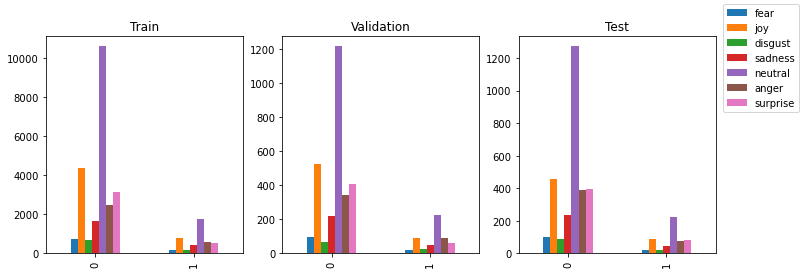

In [7]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [7]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

In [8]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

In [10]:
print(len(train_data_tokenized))
print(len(val_data_tokenized))
print(len(test_data_tokenized))

28062
3437
3501


Models

In [11]:
seeds = [666, 55, 42]

X = train_data_tokenized['dialogue_index']
Y = train_data_tokenized.select_columns(['triggers', 'emotions_id'])
seed_table = {'majority': {}, 'uniform': {},
              'model_BERT': {}, 'model_BERT_Freezed': {}}

id2emotion = df_manager.get_id2emotion()
random_clf = Baseline("uniform", X, Y)
majority_clf = Baseline("most_frequent", X, Y)
for seed in seeds:
    seed_table["uniform"][seed] = random_clf.score()
    seed_table["majority"][seed] = majority_clf.score()

In [12]:
seed_table

{'majority': {666: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions_flatten': 0.0002,
   'f1scores_triggers_flatten': 0.0001},
  55: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions_flatten': 0.0002,
   'f1scores_triggers_flatten': 0.0001},
  42: {'accuracy_emotions': 0.4392060437602452,
   'accuracy_triggers': 0.8414938350794668,
   'f1scores_emotions_flatten': 0.0002,
   'f1scores_triggers_flatten': 0.0001}},
 'uniform': {666: {'accuracy_emotions': 0.14293350438315158,
   'accuracy_triggers': 0.5053453068206115,
   'f1scores_emotions_flatten': 0.0002,
   'f1scores_triggers_flatten': 0.0001},
  55: {'accuracy_emotions': 0.140332121730454,
   'accuracy_triggers': 0.4973986173473024,
   'f1scores_emotions_flatten': 0.0002,
   'f1scores_triggers_flatten': 0.0001},
  42: {'accuracy_emotions': 0.14239897370109045,
   'accuracy_triggers': 0.5001781768940203,
   'f1scores_emo

In [13]:
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        emotions_counts = {label:0 for label in df_manager.unique_emotions}
        for sentence_emotions in data[df_manager.column_emotions_id]:
            for emotion in sentence_emotions:
                emotions_counts[emotion] = emotions_counts[emotion] + 1
        sum_of_all_emotions = sum(emotions_counts.values())
        for label in labels:
            w = (sum_of_all_emotions-emotions_counts[label])/emotions_counts[label]   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [14]:
from src.models.models import BERT_Model_Phrase_Concatenation
model_B = Model_Phrase_Concatenation(df_manager)
def try_model_Concatenation(batch_start, batch_end):
        outputs_text = model_B(utterance_ids=train_data_tokenized[batch_start:batch_end]['utterance_ids'],
                utterance_mask=train_data_tokenized[batch_start:batch_end]['utterance_mask'],
                dialogue_ids=train_data_tokenized[batch_start:batch_end]['dialogue_ids'],
                dialogue_mask=train_data_tokenized[batch_start:batch_end]['dialogue_mask'],
                utterance_index=train_data_tokenized[batch_start:batch_end]['utterance_index'],
                dialogue_index=train_data_tokenized[batch_start:batch_end]['dialogue_index'],
                token_type_ids=None)
        return outputs_text

# outputs_text = try_model_Concatenation(0, 4)
# print(outputs_text['emotion_logits'].shape)
# print(outputs_text['trigger_logits'].shape)

In [15]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].unsqueeze(1).float().to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.CrossEntropyLoss().to("cuda")        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss().to("cuda")

        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())
        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)

        loss = loss_emotions + loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="steps",
        save_strategy="steps",
        lr_scheduler_type="cosine",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index", "emotions_id_one_hot_encoding"],
    )
    pos_weight = init_pos_weight(concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized]), df_manager.emotion2id.keys(), False)
    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda pred: compute_metrics(pred, len(df_manager.emotion2id.keys())),
    )

    return trainer

In [ ]:
#intialize class for error analysis (SELECT FIRST WHICH DATASET TO USE)

from src import error
report = error.ErrorAnalysis(test_data_tokenized)
train_report = error.ErrorAnalysis(train_data_tokenized)

In [ ]:
seeds = [49]
for seed in seeds:
        set_seeds(seed)
        base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id)

        # Create trainer for Conclusion only
        trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_dir+"baseline", class_weights=False, batch_size=8, epochs=10)

        # Create trainer for Conclusion+Premises
        # trainer_freezed = get_trainer(base_model_freezed, train_dataset, val_dataset, model_dir+"baseline_freezed", class_weights=True, batch_size=1, epochs=10)
        print(f'Training BASE_MODEL with seed {seed}:')
        #trainer.evaluate(val_data_tokenized[0])

        trainer.train()

        #print(f'Training BASE_MODEL_FREEZED with seed {seed}:')
        #trainer_freezed.train()

        #add predictions to the error analysis report for later analysis
        # train_report.add_model(trainer, train_data_tokenized, 'baseline', seed)
        # report.add_model(trainer, test_data_tokenized, 'baseline', seed)

        #test_prediction_info = trainer.predict(dataset)
        #test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
        #test_metrics.append(compute_metrics([test_predictions, test_labels], list(level_2.keys())))

        ## fill seed table
        #seed_table["model_BERT"][seed] = test_bert
        #seed_table["model_BERT_Freezed"][seed] = test_CP

In [ ]:
# How to load a model
# b = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id)
# model_path = model_dir + "bert_extraction_51"
# b.load_state_dict(torch.load(model_path+"/bert_extraction_51.pth"))
# tr = get_trainer(b, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)
# tr.evaluate(test_data_tokenized)

In [ ]:
def train_extr_model(seed, freeze=False):
    set_seeds(seed)
    base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id, freeze)
    model_path = model_dir+"bert_extraction_freeze_"+str(seed) if freeze else model_dir+"bert_extraction_"+str(seed)

    trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)

    print(f'Training EXTRACTION MODEL with seed {seed}:')

    trainer.train()
    save_name = "/bert_extraction_freeze_"+str(seed)+".pth" if freeze else "/bert_extraction_"+str(seed)+".pth"
    torch.save(base_model.state_dict(), model_path+save_name)

In [ ]:
# Recover from checkpoint
# set_seeds(77)
# base_model = Model_Phrase_Extraction(len(df_manager.unique_emotions), tokenizer.sep_token_id)
# model_path = model_dir+"bert_extraction_"+str(77)

# trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_path, class_weights=True, batch_size=4, epochs=5)

# print(f'Resume training of model with seed 77:')

# trainer.train(model_path+"/checkpoint-24000")
# torch.save(base_model.state_dict(), model_path+"/bert_extraction_"+str(77)+".pth")

### ERROR ANALYSIS
Check if you have added models to the Error analysis class. After which you can call all the functions you want. Predictions should be stored inside a dataframe, emotions and triggers in two separated columns. The columns should have respectively "<MODEL_NAME>_<SEED>" and "<MODEL_NAME>_<SEED>_T" names. If they don't have been added but you still have the model, you can add predictions directly with .add_predictions()... Do it twice, onece adding emtions predictions and once adding trigger predictions. When adding, the model name should be just the name.

In [51]:
from src import error
import importlib
importlib.reload(error)

<module 'src.error' from 'c:\\Users\\cacio\\Desktop\\jacopo\\scuola\\UNIBO MASTER\\NATURAL LANGUAGE PROCESSING\\project\\ediref\\src\\error.py'>

In [52]:
report = error.ErrorAnalysis(test_data_tokenized)

In [53]:
report.add_model(trainer, test_data_tokenized, 'baseline', seeds[0])

100%|██████████| 315/315 [00:08<00:00, 38.44it/s]

torch.Size([315, 7]) torch.Size([315, 1])


'Successfullty added model!'

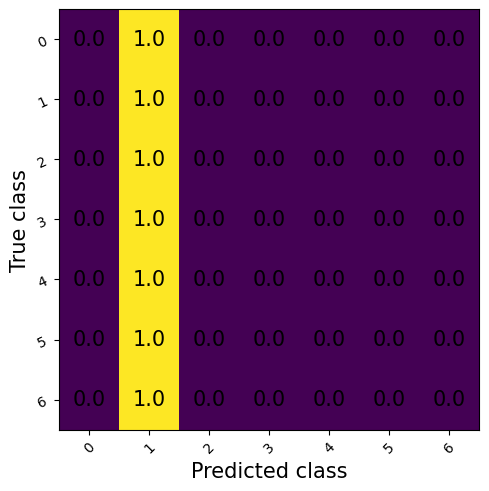

In [54]:
_ = report.get_confusion_matrix('baseline_666', plot = True)

In [55]:
table = report.get_performance_table(metrics = ['accuracy','f1_macro','f1_micro','f1_weighted'])
report_df = pd.DataFrame(table.values())
report_df = report_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
report_df

,name,accuracy,f1_micro,f1_macro,f1_weighted,accuracy_t,f1_t
0,baseline_666,0.142857,0.473016,0.091749,0.30379,0.809524,0.0


In [57]:
# ALL IS WORKING FINE
report.get_trigger_effect('baseline_666')
report.get_confusion_matrix('baseline_666', plot = False)
report.get_confusion_matrix('baseline_666_t', plot = False)
report.get_precision_recall('baseline_666', plot = False)
report.get_precision_recall('baseline_666_t', plot = False)
report.get_emotions_table()
report.get_misclassified('baseline_666')
report.get_misclassified('baseline_666_t')
report.get_performance_table()
report.get_trigger_table()
report.get_utterance_ranking('baseline_666')
report.get_utterance_ranking('baseline_666_t')


,accuracy,dialogue_len
episode,,
utterance_2863,0.200000,10.0
utterance_2848,0.333333,15.0
utterance_3191,0.333333,3.0
utterance_1443,0.400000,5.0
utterance_1682,0.600000,5.0
utterance_3791,0.600000,5.0
utterance_2199,0.666667,6.0
utterance_1696,0.666667,3.0
utterance_1919,0.666667,3.0


In [39]:
#Some functions return dict or list of dict. check usage in error_analysis.ipynb If you want dataframes visualization, you can do something like this
table = report.get_emotions_table()
print(table)
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
table_df

{'baseline_666': {'name': 'baseline_666', '0_acc': tensor(0.), '1_acc': tensor(1.), '2_acc': tensor(0.), '3_acc': tensor(0.), '4_acc': tensor(0.), '5_acc': tensor(0.), '6_acc': tensor(0.), '0_f1': tensor(0.), '1_f1': tensor(0.6422), '2_f1': tensor(0.), '3_f1': tensor(0.), '4_f1': tensor(0.), '5_f1': tensor(0.), '6_f1': tensor(0.)}, 'support': {'1_acc': 149, '1_f1': 149, '4_acc': 45, '4_f1': 45, '3_acc': 36, '3_f1': 36, '6_acc': 34, '6_f1': 34, '2_acc': 29, '2_f1': 29, '5_acc': 11, '5_f1': 11, '0_acc': 11, '0_f1': 11, 'name': 'support'}}


,name,0_acc,1_acc,2_acc,3_acc,4_acc,5_acc,6_acc,0_f1,1_f1,2_f1,3_f1,4_f1,5_f1,6_f1
0,baseline_666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642241,0.0,0.0,0.0,0.0,0.0
1,support,11.0,149.0,29.0,36.0,45.0,11.0,34.0,11.0,149.000000,29.0,36.0,45.0,11.0,34.0


In [58]:
#TABLE FOR TRIGGER ANALYSIS
table = report.get_trigger_table()
values = [np.array([np.array([v for v in scores.values()]).flatten() for scores in model.values()]).flatten().tolist() for model in table.values()]
columns = next(iter(table.values())).keys()
sub_columns = next(iter(next(iter(table.values())).values())).keys()
indexes = table.keys()
report_df = pd.DataFrame(values, columns = pd.MultiIndex.from_product([tuple(columns), tuple(sub_columns)]), index=indexes)
report_df

emotion_accuracy         support      
                    correct_t bad_t correct_t bad_t
baseline_666              0.0  0.42       0.0  60.0